# Image inpainting

Example of image inpainting using NIHT


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pylops

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

In [2]:
# Load image
img = cv2.imread('../data/cameraman.jpg', 0) 

delta = 0.5
rho = 0.1
p = round(delta * 512**2) # number of samples
s = round(p * rho) # sparsity

mask = np.random.choice(512**2,p,replace = False)
P_omega = EntryWise((len(mask),512**2), mask)
Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet = 'db4')

img_coeff = Wave2d.matvec(img.flatten())

The model is
$$ \min_c \| P_\Omega( \Psi^*(c) )) - b \|_2 \qquad \mathrm{s.t.}\qquad \|c\|_0 \leq s$$
where $P_\Omega$ is an entrywise subsampling and $\Psi$ is an 2D Wavelet transform.

In [3]:
A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100)

In [4]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm	     xdist
    1	+4.8325733471796796e+07	2.42087646e+04
    2	+2.2157259998210058e+07	9.83114779e+03
    3	+1.4965605274450224e+07	6.65691520e+03
    4	+1.1633475366907736e+07	5.47094238e+03
    5	+1.1051806034461997e+07	4.82358277e+03
    6	+9.7305776686658189e+06	4.70144787e+03
    7	+9.7650109422612693e+06	4.41147995e+03
    8	+9.2696530662888400e+06	4.41927843e+03
    9	+9.4081805086184964e+06	4.30572945e+03
   10	+9.0717695745756906e+06	4.33778296e+03
   11	+9.1564148801656589e+06	4.25952335e+03
   12	+8.9748050890580732e+06	4.27934922e+03
   13	+8.9832932718413528e+06	4.23669803e+03
   14	+8.9211571116789822e+06	4.23870104e+03
   15	+8.9347217621548083e+06	4.22401636e+03
   16	+8.8995714503079690e+06	4.22722646e+03
   17	+8.9049779237509146e+06	4.21890304e+03
   18	+8.8934004529991392e+06	4.22018434e+03
   19	+8.9000169571635202e+06	4.21744009e+03
   20	+8.8906071438829899e+06	4.21900864e+03
   21	+8.8944249466510899e+06	4.21677771e+03
   22	+8

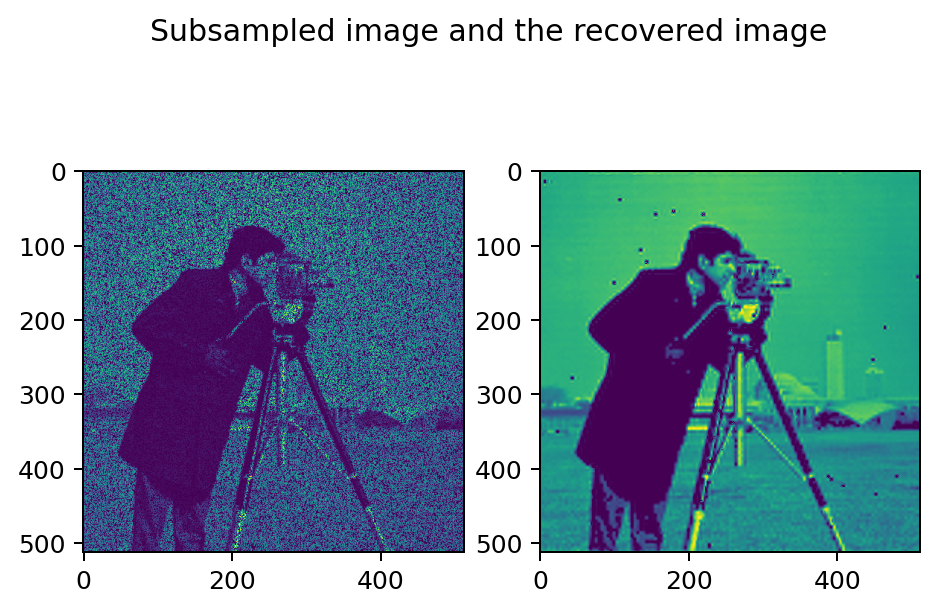

In [5]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(512,512), vmin = 0, vmax=256)
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(512,512), vmin = 0, vmax=256)
fig.show()

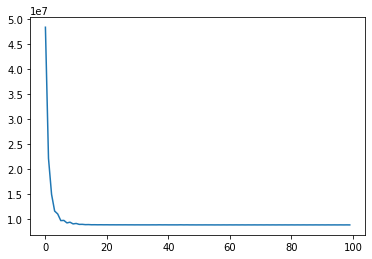

In [6]:
plt.plot(opt_log['iterations']['fx'])